In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, balanced_accuracy_score
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Define Evaluation Framework

We will iterate through all directories in `data/synthetic` (representing imputation methods) and all files within them (representing synthesis methods).

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = {}
    
    # 1. Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RF'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_rf),
        'f1_weighted': f1_score(y_test, y_pred_rf, average='weighted')
    }
    
    # 2. CatBoost
    cb = CatBoostClassifier(iterations=500, random_seed=42, verbose=0)
    cb.fit(X_train, y_train)
    y_pred_cb = cb.predict(X_test)
    results['CatBoost'] = {
        'accuracy': accuracy_score(y_test, y_pred_cb),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_cb),
        'f1_weighted': f1_score(y_test, y_pred_cb, average='weighted')
    }
    
    # 3. Stacking (RF + CatBoost)
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('cb', CatBoostClassifier(iterations=500, random_seed=42, verbose=0))
    ]
    stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    stacking.fit(X_train, y_train)
    results['Stacking'] = {
        'accuracy': accuracy_score(y_test, y_pred_stack),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_stack),
        'f1_weighted': f1_score(y_test, y_pred_stack, average='weighted')
    }
    
    return results

In [35]:
from sklearn.impute import SimpleImputer

print("Evaluating Baseline (Original Data + Mean Imputation)...")

raw_path = '../data/raw/uc_diagnostic_tests.csv'
if os.path.exists(raw_path):
    # FIX: Add decimal=',' for European format
    df_raw = pd.read_csv(raw_path, decimal=',')
    
    # 2. Preprocess
    X_raw = df_raw.drop(columns=['mayo'])
    y_raw = df_raw['mayo']
    
    # Simple Mean Imputation
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns)
    
    # 3. Split
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_imputed, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
    
    # 4. Train & Evaluate
    # RF
    rf_b = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_b.fit(X_train_b, y_train_b)
    y_pred_rf_b = rf_b.predict(X_test_b)
    score_rf_b = balanced_accuracy_score(y_test_b, y_pred_rf_b)
    
    # CatBoost
    cb_b = CatBoostClassifier(iterations=500, random_seed=42, verbose=0)
    cb_b.fit(X_train_b, y_train_b)
    y_pred_cb_b = cb_b.predict(X_test_b)
    score_cb_b = balanced_accuracy_score(y_test_b, y_pred_cb_b)

    # Stacking
    est_b = [('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('cb', CatBoostClassifier(iterations=500, random_seed=42, verbose=0))]
    stack_b = StackingClassifier(estimators=est_b, final_estimator=LogisticRegression())
    stack_b.fit(X_train_b, y_train_b)
    y_pred_stack_b = stack_b.predict(X_test_b)
    score_stack_b = balanced_accuracy_score(y_test_b, y_pred_stack_b)
    
    print(f"Baseline Results (Mean Imputation, N={len(df_raw)}):")
    print(f"  RF Balanced Acc:       {score_rf_b:.4f}")
    print(f"  CatBoost Balanced Acc: {score_cb_b:.4f}")
    print(f"  Stacking Balanced Acc: {score_stack_b:.4f}")

else:
    print(f"File not found: {raw_path}")

Evaluating Baseline (Original Data + Mean Imputation)...
Baseline Results (Mean Imputation, N=252):
  RF Balanced Acc:       0.4128
  CatBoost Balanced Acc: 0.3973
  Stacking Balanced Acc: 0.3868


## 2. Run Iteration over All Datasets

In [36]:
from sklearn.metrics import precision_recall_fscore_support

synthetic_root = '../data/synthetic'
all_results = []

# Track Best Model
best_score = -1
best_model_data = {} 

def get_metrics(y_true, y_pred, model_name, imp, syn):
    # Calculate Precision, Recall, F1 (weighted to handle class imbalance)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    
    return {
        'imputation': imp,
        'synthesis': syn,
        'model': model_name,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_weighted': f1,
        'precision_weighted': precision,
        'recall_weighted': recall
    }

for imputation_method in os.listdir(synthetic_root):
    imputation_path = os.path.join(synthetic_root, imputation_method)
    if not os.path.isdir(imputation_path): continue
    
    for file in os.listdir(imputation_path):
        if not file.endswith('.csv'): continue
        
        synthesis_method = file.replace('uc_diagnostics_', '').replace('.csv', '')
        file_path = os.path.join(imputation_path, file)
        
        # Load & Preprocess
        df = pd.read_csv(file_path)
        X = df.drop(columns=['mayo'])
        y = df['mayo']
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        print(f"Processing: {imputation_method} + {synthesis_method}...")
        
        # 1. Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        all_results.append(get_metrics(y_test, y_pred, 'RF', imputation_method, synthesis_method))
        
        if balanced_accuracy_score(y_test, y_pred) > best_score:
            best_score = balanced_accuracy_score(y_test, y_pred)
            best_model_data = {'X_test': X_test, 'y_test': y_test, 'estimator': rf, 'title': f"Best: {imputation_method}+{synthesis_method} (RF)"}

        # 2. CatBoost
        cb = CatBoostClassifier(iterations=500, random_seed=42, verbose=0)
        cb.fit(X_train, y_train)
        y_pred = cb.predict(X_test)
        all_results.append(get_metrics(y_test, y_pred, 'CatBoost', imputation_method, synthesis_method))

        if balanced_accuracy_score(y_test, y_pred) > best_score:
            best_score = balanced_accuracy_score(y_test, y_pred)
            best_model_data = {'X_test': X_test, 'y_test': y_test, 'estimator': cb, 'title': f"Best: {imputation_method}+{synthesis_method} (CatBoost)"}

        # 3. Stacking
        estimators = [('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('cb', CatBoostClassifier(iterations=500, random_seed=42, verbose=0))]
        stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
        stack.fit(X_train, y_train)
        y_pred = stack.predict(X_test)
        all_results.append(get_metrics(y_test, y_pred, 'Stacking', imputation_method, synthesis_method))

        if balanced_accuracy_score(y_test, y_pred) > best_score:
            best_score = balanced_accuracy_score(y_test, y_pred)
            best_model_data = {'X_test': X_test, 'y_test': y_test, 'estimator': stack, 'title': f"Best: {imputation_method}+{synthesis_method} (Stacking)"}

results_df = pd.DataFrame(all_results)
display(results_df.head())
print(f"Done! Best Score: {best_score:.4f} ({best_model_data['title']})")

Processing: knn + ctgan...
Processing: knn + smote...
Processing: knn + adasyn...
Processing: knn + tvae...
Processing: softimpute + ctgan...
Processing: softimpute + smote...
Processing: softimpute + adasyn...
Processing: softimpute + tvae...
Processing: gain + ctgan...
Processing: gain + smote...
Processing: gain + adasyn...
Processing: gain + tvae...
Processing: mice + ctgan...
Processing: mice + smote...
Processing: mice + adasyn...
Processing: mice + tvae...
Processing: pmm + ctgan...
Processing: pmm + smote...
Processing: pmm + adasyn...
Processing: pmm + tvae...


,imputation,synthesis,model,accuracy,balanced_accuracy,f1_weighted,precision_weighted,recall_weighted
0,knn,ctgan,RF,0.504950,0.479451,0.489311,0.508594,0.504950
1,knn,ctgan,CatBoost,0.514851,0.494572,0.504511,0.505233,0.514851
2,knn,ctgan,Stacking,0.524752,0.507341,0.514252,0.518266,0.524752
3,knn,smote,RF,0.676056,0.675654,0.658759,0.683581,0.676056
4,knn,smote,CatBoost,0.661972,0.662582,0.646933,0.653777,0.661972


Done! Best Score: 0.7674 (Best: gain+adasyn (Stacking))


## 3. Results Visualization

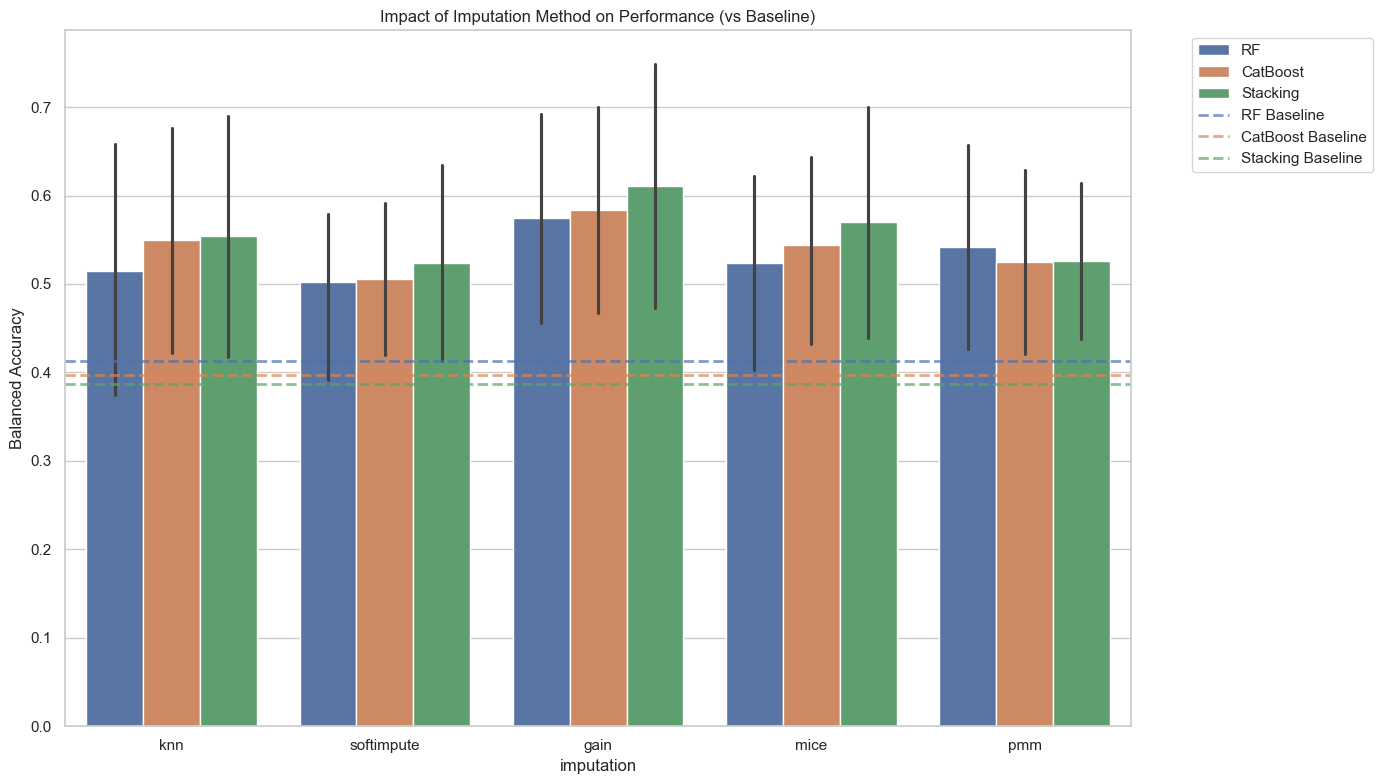

In [37]:
colors = {'RF': 'C0', 'CatBoost': 'C1', 'Stacking': 'C2'}
# --- Plot 1: Imputation Impact with Baselines ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_df, x='imputation', y='balanced_accuracy', hue='model')
# Add Horizontal Lines for Baseline
# (We use the scores you calculated in the previous Baseline cell: score_rf_b, score_cb_b, score_stack_b)
plt.axhline(y=score_rf_b, color=colors['RF'], linestyle='--', linewidth=2, label='RF Baseline', alpha=0.7)
plt.axhline(y=score_cb_b, color=colors['CatBoost'], linestyle='--', linewidth=2, label='CatBoost Baseline', alpha=0.7)
plt.axhline(y=score_stack_b, color=colors['Stacking'], linestyle='--', linewidth=2, label='Stacking Baseline', alpha=0.7)
plt.title('Impact of Imputation Method on Performance (vs Baseline)')
plt.ylabel('Balanced Accuracy')
# Fix Legend to show both bars and lines
handles, labels = ax.get_legend_handles_labels()
# We usually just want the first 3 (bars) + the last 3 (lines) if they duplicate
# But allowing default legend is usually fine, or you can simplify it:
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../results_imputation_impact_with_baseline.png', dpi=300)
plt.show()

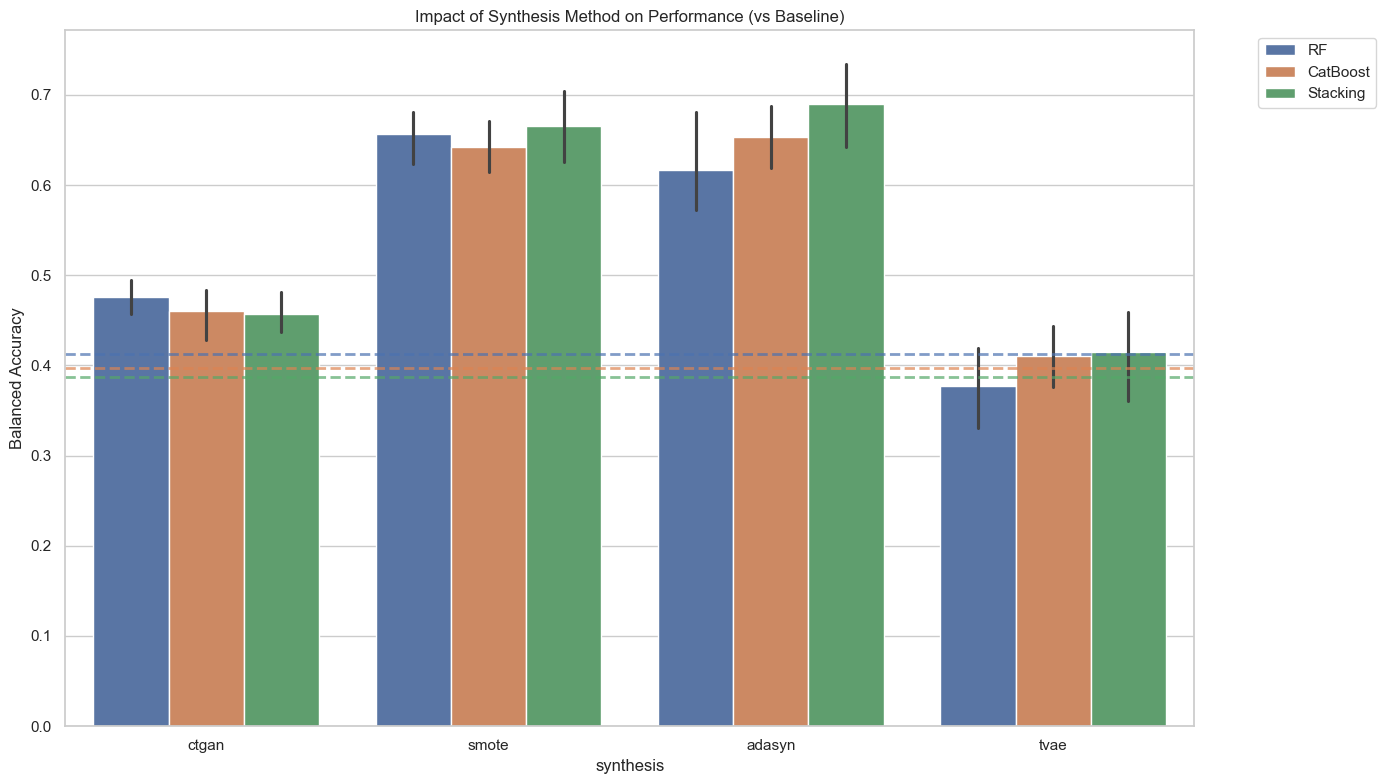

In [38]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_df, x='synthesis', y='balanced_accuracy', hue='model')
# Add Lines
plt.axhline(y=score_rf_b, color=colors['RF'], linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(y=score_cb_b, color=colors['CatBoost'], linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(y=score_stack_b, color=colors['Stacking'], linestyle='--', linewidth=2, alpha=0.7)
plt.title('Impact of Synthesis Method on Performance (vs Baseline)')
plt.ylabel('Balanced Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../results_synthesis_impact_with_baseline.png', dpi=300)
plt.show()

## 4. Best Performing Combination

In [39]:
best_row = results_df.sort_values(by='balanced_accuracy', ascending=False).iloc[0]
print("Best Performing Configuration:")
print(best_row)

print("\nTop 5 Overall:")
display(results_df.sort_values(by='balanced_accuracy', ascending=False).head(5))

Best Performing Configuration:
imputation                gain
synthesis               adasyn
model                 Stacking
accuracy              0.774648
balanced_accuracy     0.767361
f1_weighted           0.771491
precision_weighted    0.776836
recall_weighted       0.774648
Name: 32, dtype: object

Top 5 Overall:


,imputation,synthesis,model,accuracy,balanced_accuracy,f1_weighted,precision_weighted,recall_weighted
32,gain,adasyn,Stacking,0.774648,0.767361,0.771491,0.776836,0.774648
29,gain,smote,Stacking,0.732394,0.731209,0.734386,0.741449,0.732394
30,gain,adasyn,RF,0.732394,0.725420,0.724099,0.733995,0.732394
44,mice,adasyn,Stacking,0.735294,0.724470,0.729725,0.742545,0.735294
31,gain,adasyn,CatBoost,0.718310,0.710069,0.706029,0.717715,0.718310


## 5. Heatmap of Results (Stacking Model)

Let's see how the Stacking model performs across all combinations.

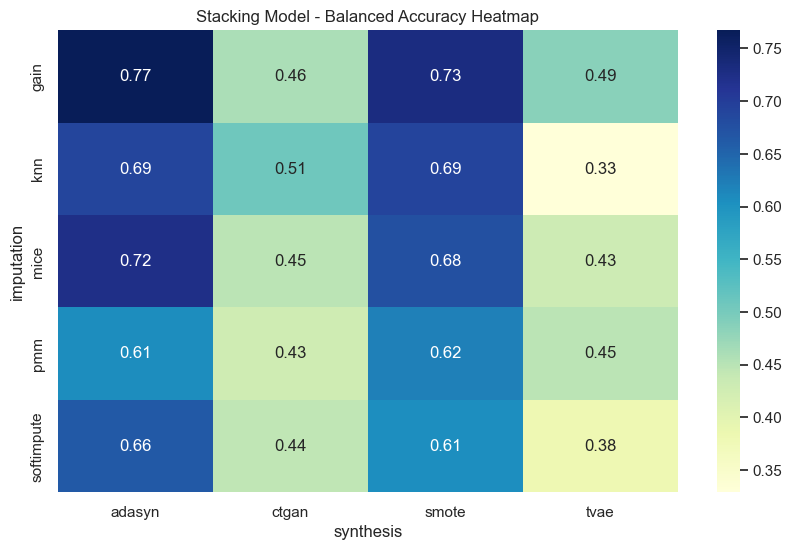

In [40]:
stacking_results = results_df[results_df['model'] == 'Stacking']
matrix = stacking_results.pivot(index='imputation', columns='synthesis', values='balanced_accuracy')

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap='YlGnBu')
plt.title('Stacking Model - Balanced Accuracy Heatmap')
plt.show()

<Figure size 800x600 with 0 Axes>

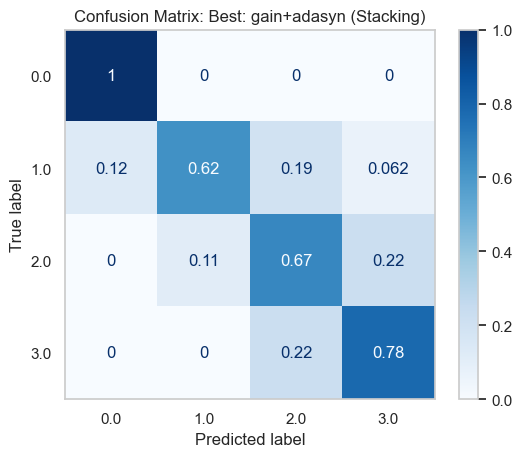

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix using stored best model data
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model_data['estimator'], 
    best_model_data['X_test'], 
    best_model_data['y_test'], 
    # display_labels=['Moderate', 'Severe'],  <-- REMOVED THIS LINE
    cmap='Blues',
    normalize='true'
)
plt.title(f"Confusion Matrix: {best_model_data['title']}")
plt.grid(False)
plt.savefig('../results_best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()